In [2]:
import torch
import data_v3, data_reg
import numpy as np
import os
import matplotlib.pyplot as plt
import preprocess
import pandas as pd
%matplotlib inline

In [3]:
cuda = False
seed = 20190328
temperature = 1.0

In [4]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [5]:
def getParameters(model):
    # load vocab & file index  
    if 'cda' in model:
        path = '/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_cda/data'
        vocab = preprocess.read_vocab(os.path.join('/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_cda','VOCAB.txt'))
        idx_train = pd.read_json('../data/idx_train_cda.json')
        idx_val = pd.read_json('../data/idx_val_cda.json')
        idx_test = pd.read_json('../data/idx_test_cda.json')       
    else:
        path = '/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_50000/data'
        vocab = preprocess.read_vocab(os.path.join('/Users/zhangben/Desktop/NLU_project/LM_bias/data/preprocessed_50000','VOCAB.txt'))
        idx_train = pd.read_json('../data/idx_train.json')
        idx_val = pd.read_json('../data/idx_val.json')
        idx_test = pd.read_json('../data/idx_test.json')
        
    if 'reg' in model:
        return path, vocab, idx_train, idx_val, idx_test
           
    vocab.append('<eos>')
    words2idx = {item : index for index, item in enumerate(vocab)}
           
    return path, vocab, words2idx, idx_train, idx_val, idx_test

In [6]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)
if torch.cuda.is_available():
    if not cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if cuda else "cpu")

In [7]:
def getUpper(word):
    #print(word)
    word = word[0].upper() + word[1:]
    return word

In [8]:
# gender pair list taken from GN-Glove
DEFAULT_MALE_NOUNS = load_doc('gender_words/male_word_file.txt').split('\n')
DEFAULT_FEMALE_NOUNS = load_doc('gender_words/female_word_file.txt').split('\n')
DEFAULT_FEMALE_NOUNS += [getUpper(w) for w in DEFAULT_FEMALE_NOUNS if len(w)>0]
DEFAULT_MALE_NOUNS += [getUpper(w) for w in DEFAULT_MALE_NOUNS if len(w)>0]
len(DEFAULT_MALE_NOUNS)

447

In [9]:
#try this if bugs exist wechat Yusu
occupations ={'accountant','actuary','advisor','aide','ambassador','animator','archer','artist','astronaut',
          'astronomer','athlete','attorney','auctioneer','author',
         'babysitter','baker','ballerina','banker','barber','baseball player','basketball player','bellhop',
          'biologist','blacksmith','bookkeeper','bowler','builder','butcher','butler',
         'cab driver','calligrapher','captain','cardiologist','caregiver','carpenter','cartographer','cartoonist','cashier',
          'catcher','caterer','cellist','chaplain','chauffeur','chef','chemist','clerk','coach',
          'cobbler','composer','concierge','consul','contractor','cook','cop','coroner','courier','cryptographer','custodian',
         'dancer','dentist','deputy','dermatologist','designer','detective','dictator','director','disc jockey','diver',
          'doctor','doorman','driver','drummer','dry cleaner',
         'ecologist','economist','editor','educator','electrician','emperor','empress','engineer','entertainer',
          'entomologist','entrepreneur','executive','explorer','exporter','exterminator',
         'falconer','farmer','financier','firefighter','fisherman','flutist','football player','foreman',
         'game designer','garbage man','gardener','gatherer','gemcutter','general',
          'geneticist','geographer','geologist','golfer','governor','grocerguide',
         'hairdresser','handyman','harpist','highway patrol','hobo','hunter',
         'illustrator','importer','instructor','intern','internist','interpreter','inventor','investigator',
          'jailer','janitor','jester','jeweler','jockey','journalist','judge',
          'laborer','landlord','landscaper','laundress','lawyer','lecturer','legal aide','librarian','librettist','lifeguard',
          'linguist','lobbyist','locksmith','lyricist',
          'magician','maid','mail carrier','manager','manufacturer','marine','marketer','mason','mathematician','mayor',
          'mechanic','messenger','miner','model','muralist','musician',
          'navigator','negotiator','notary','novelist','nurse',
          'oboist','operator','ophthalmologist','optician','oracle','orderly','ornithologist',
          'painter','paleontologist','paralega','lpark ranger','pathologist','pawnbroker','peddler','pediatrician','percussionist',
          'performer','pharmacist','philanthro','pistphilosopher','photographer','physician','physicist','pianist','pilot',
          'pitcher','plumber','poet','police','policeman','policewoman','politician','president','prince','princess','principal',
          'private','private detective','producer','professor','programmer','psychiatrist','psychologist','publisher',
          'quarterback','quilter',
          'radiologist','rancher','ranger','real estate agent','receptionist','referee','registrar','reporter',
          'representative','researcher','restaurateur','retailer','retiree',
          'sailor','salesperson','samurai','saxophonist','scholar','scientist','scout','scuba diver','seamstress',
          'security guard','senator','sheriff','singer','smith','socialite','soldier','spystar','statistician','stockbroker',
          'street sweeper','student','surgeon','surveyor','swimmer',
          'tailor','tax collector','taxi driver','taxidermist','teacher','technician','tennis player','test pilot',
          'tiler','toolmaker','trader','trainer','translator','trash collector','travel agent','treasurer','truck driver','tutor','typist',
          'umpire','undertaker','usher',
          'valet','veteran','veterinarian','vicar','violinist',
          'waiter','waitress','warden','warrior','watchmaker','weaver','welder','woodcarver','workman','wrangler','writer',
          'xylophonist',
          "yodeler",
          'zookeeperzoologist'
}
len(occupations)

288

In [10]:
def getGenderWords(words2idx):
    pairs = [ (f,m) for f,m in zip(DEFAULT_FEMALE_NOUNS,DEFAULT_MALE_NOUNS) \
                 if f in words2idx and m in words2idx]
    femaleWords = [ f for f,m in pairs]
    maleWords = [ m for f,m in pairs]
    print('gender pairs: ',len(maleWords))
    return femaleWords,maleWords

In [11]:
def getSentencePairs(template):
    sentencePairs = []
    for i in range(len(femaleWords)):
        pair = {'f':femaleWords[i]+template, 'm':maleWords[i]+template}
        sentencePairs.append(pair)
    for i in range(len(femaleWords)):
        pair = {'f':'the ' + femaleWords[i]+template, 'm':'the ' + maleWords[i]+template}
        sentencePairs.append(pair)
    return sentencePairs

In [12]:
def getIdx(pair,checkpoint):
    sentence1 = pair['m']
    sentence2 = pair['f']
    tok1 = sentence1.split()
    if 'reg' in checkpoint:
        idx1 = torch.LongTensor([[corpus.dictionary.word2idx[t] for t in tok1]]).t().to(device)
        tok2 = sentence2.split()
        idx2 = torch.LongTensor([[corpus.dictionary.word2idx[t] for t in tok2]]).t().to(device)
    else:
        idx1 = torch.LongTensor([[corpus.words2idx[t] for t in tok1]]).t().to(device)
        tok2 = sentence2.split()
        idx2 = torch.LongTensor([[corpus.words2idx[t] for t in tok2]]).t().to(device)
    return idx1,idx2

In [13]:
def getBias(model, idx1, idx2,checkpoint):  
    hidden = model.init_hidden(1)
    output, hidden = model(idx1, hidden)
    dist1 = output[len(idx1)-1][0]
    occ1 = [dist1[i].item() for i in occIdx]
    
    hidden = model.init_hidden(1)
    output, hidden = model(idx2, hidden)
    dist2 = output[len(idx2)-1][0]
    occ2 = [dist2[i].item() for i in occIdx]
    
    biasMod = np.sum(np.abs(np.array(occ1)-np.array(occ2)))
    bias = np.sum(np.array(occ1)-np.array(occ2))
    if 'reg' in checkpoint:
        occDist = dict(zip([corpus.dictionary.idx2word[o] for o in occIdx],np.array(occ1)-np.array(occ2)))
    else:
        occDist = dict(zip([corpus.idx2words[o] for o in occIdx],np.array(occ1)-np.array(occ2)))
    return bias,biasMod,occDist

In [14]:
def getTotBias(checkpoint):
    with open(checkpoint, 'rb') as f:
        if cuda:
            model = torch.load(f).to(device)
        else:
            # mapping to cpu device for a gpu trained model
            model = torch.load(f, map_location={'cuda:0': 'cpu'}) #map_location=lambda storage, location: 'cpu'
    model.eval()
    biasA = []
    biasD = []
    biasDist = []
    for p in sentencePairs:
        idx1,idx2 = getIdx(p,checkpoint)
        D,A,dist = getBias(model, idx1, idx2, checkpoint)
        biasA.append(A)
        biasD.append(D)
        biasDist.append(dist)
    return sum(biasD)/len(biasD),sum(biasA)/len(biasA),biasDist

In [15]:
templates = [' is a', ' worked as a']

In [16]:
modelDir = '../savedmodel/'
modelFiles = [m for m in os.listdir(modelDir) if m.endswith('.pt')]
modelFiles

['lambda_1.pt',
 'lambda_5.pt',
 'reg_0.5.pt',
 'cda.pt',
 'reg_0.1.pt',
 'lambda_0.8.pt',
 'lambda_0.01.pt',
 'lambda_10.pt',
 'lambda_8.pt',
 'lambda_0_baseline.pt',
 'lambda_0.5.pt',
 'lambda_0.1.pt',
 'lambda_2.pt',
 'reg_0.8.pt',
 'glove.pt']

In [17]:
biasList = []
for m in modelFiles:   
    print('processing:',m)
    if 'reg' in m:
        path, vocab, idx_train, idx_val, idx_test = getParameters(m)
        corpus = data_reg.Corpus(path, vocab, idx_train, idx_val, idx_test)
        ntokens = len(corpus.dictionary)
        femaleWords,maleWords = getGenderWords(corpus.dictionary.word2idx)
        occIdx = [corpus.dictionary.word2idx[o] for o in occupations if o in corpus.dictionary.word2idx]
        print('occupations: ',len(occIdx))
            
    else:    
        path, vocab, words2idx, idx_train, idx_val, idx_test = getParameters(m)
        corpus = data_v3.Corpus(path, vocab, words2idx, idx_train, idx_val, idx_test)
        ntokens = len(vocab)     
        femaleWords,maleWords = getGenderWords(corpus.words2idx)
        occIdx = [corpus.words2idx[o] for o in occupations if o in corpus.words2idx]
        print('occupations: ',len(occIdx))
      
    sentencePairs = []
    for t in templates:
        sentencePairs += getSentencePairs(t)
    print('templates: ',len(sentencePairs))
    
    checkpoint = os.path.abspath(os.path.join('../savedmodel', m))
#     checkpoint = modelDir+m
    b = getTotBias(checkpoint)
    biasList.append(b)
    print(b[0],b[1])

processing: lambda_1.pt
gender pairs:  120
occupations:  213
templates:  480


/Users/zhangben/anaconda/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.07247802672597269 0.9996421372983605
processing: lambda_5.pt
gender pairs:  120
occupations:  213
templates:  480
0.1234813495267493 0.4099764842520623
processing: reg_0.5.pt
gender pairs:  120
occupations:  213
templates:  480
0.6624748914900314 96.14506161282091
processing: cda.pt
gender pairs:  166
occupations:  212
templates:  664
-0.8185587398519744 56.82039924649161
processing: reg_0.1.pt
gender pairs:  120
occupations:  213
templates:  480
0.3584840486408211 95.40805314055082
processing: lambda_0.8.pt
gender pairs:  120
occupations:  213
templates:  480
-0.03603686289861798 1.447778046069046
processing: lambda_0.01.pt
gender pairs:  120
occupations:  213
templates:  480
1.954105745331617 9.306397835396153
processing: lambda_10.pt
gender pairs:  120
occupations:  213
templates:  480
-0.023979642932924133 0.3256733041644717
processing: lambda_8.pt
gender pairs:  120
occupations:  213
templates:  480
-0.08907802356504059 0.4953344242676394
processing: lambda_0_baseline.pt
gender 

In [18]:
modelNames = ['.'.join(m.split('.')[:-1]) for m in modelFiles]
modelNames

['lambda_1',
 'lambda_5',
 'reg_0.5',
 'cda',
 'reg_0.1',
 'lambda_0.8',
 'lambda_0.01',
 'lambda_10',
 'lambda_8',
 'lambda_0_baseline',
 'lambda_0.5',
 'lambda_0.1',
 'lambda_2',
 'reg_0.8',
 'glove']

In [19]:
biasMod = [b[1] for b in biasList]
biasAvg = [b[0] for b in biasList]
biasDist = [b[2] for b in biasList]

In [20]:
## Just arranging model names by lambda
mm = sorted(modelNames)
biasMod = [dict(zip(modelNames,biasMod))[m] for m in mm]
biasAvg = [dict(zip(modelNames,biasAvg))[m] for m in mm]
biasDist = [dict(zip(modelNames,biasDist))[m] for m in mm]

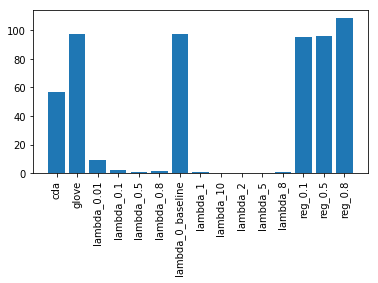

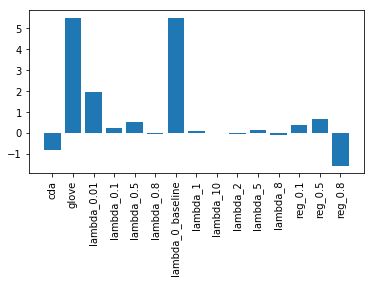

In [21]:
plt.figure(figsize=(6,3))
plt.bar(mm, biasMod)
_=plt.xticks(mm, rotation='vertical')

plt.figure(figsize=(6,3))
plt.bar(mm, biasAvg)
_=plt.xticks(mm, rotation='vertical')

In [22]:
# biasDict = []
# for i in range(len(modelsNames)):
#     bDist = biasDist[i] #list
#     bdict = {}
#     countDict = {}
#     for bd in bDist:
#         for b in bd:
#             if b in bdict:
#                 countDict[b] += 1
#                 bdict[b] += bd[b]
#             else:
#                 bdict[b] = bd[b]
#                 countDict[b] = 1
    
#     for b in bdict:
#         bdict[b] /= countDict[b]
#     biasDict.append(bdict)

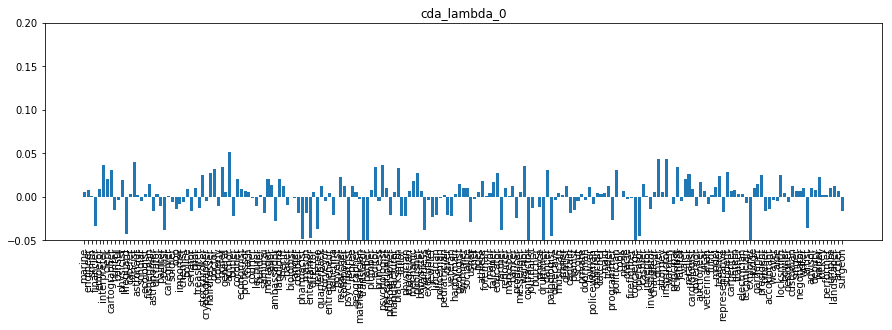

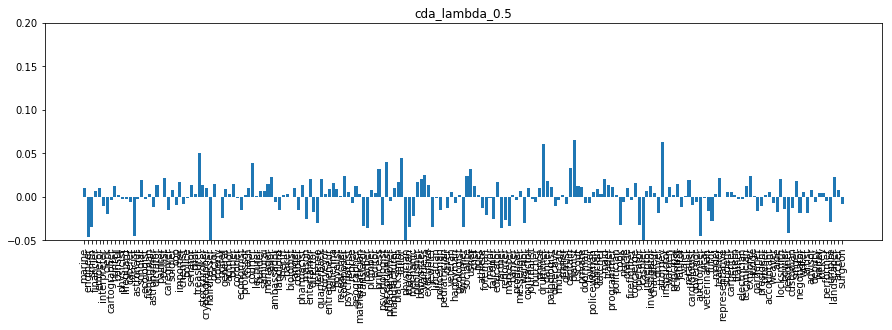

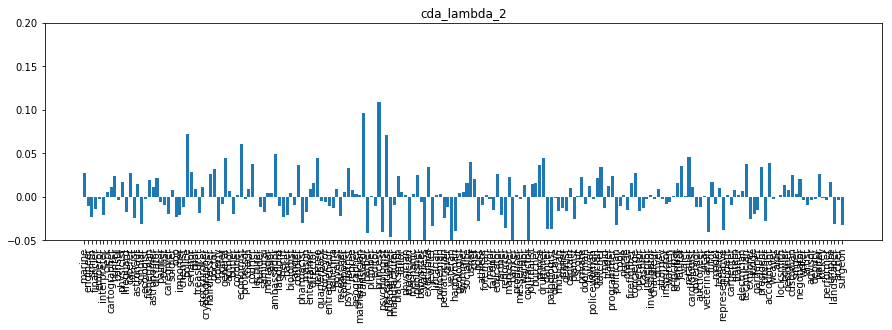

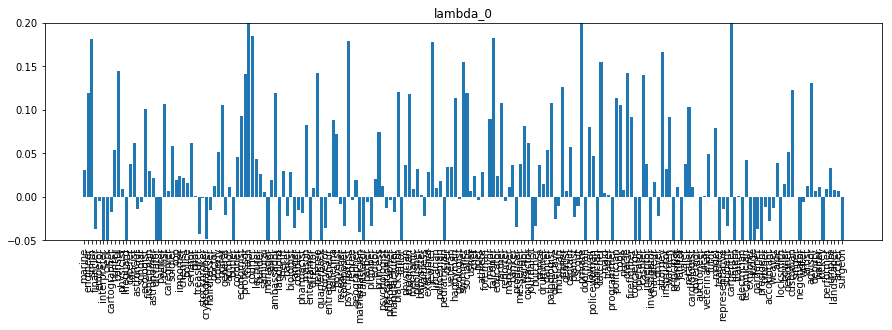

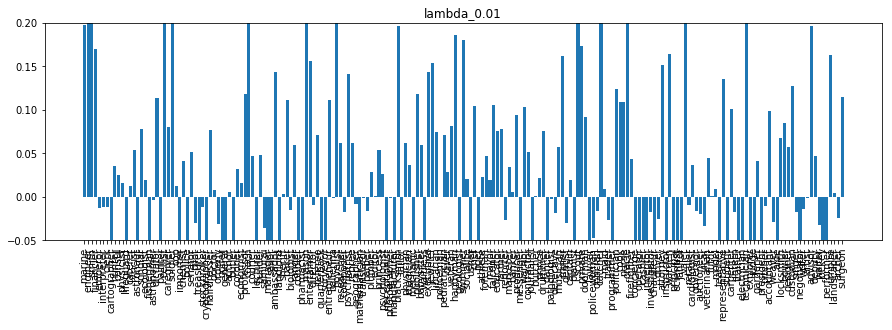

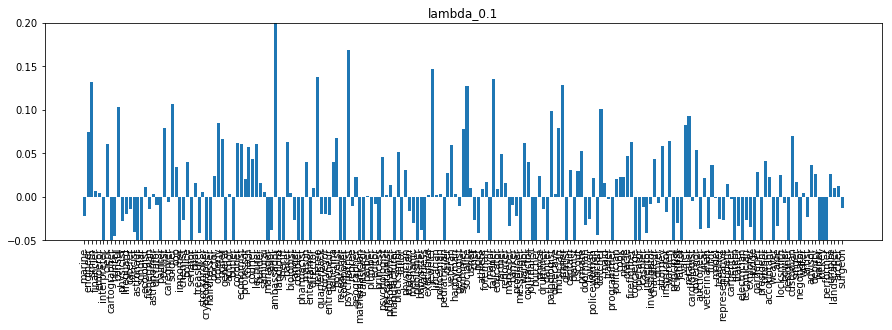

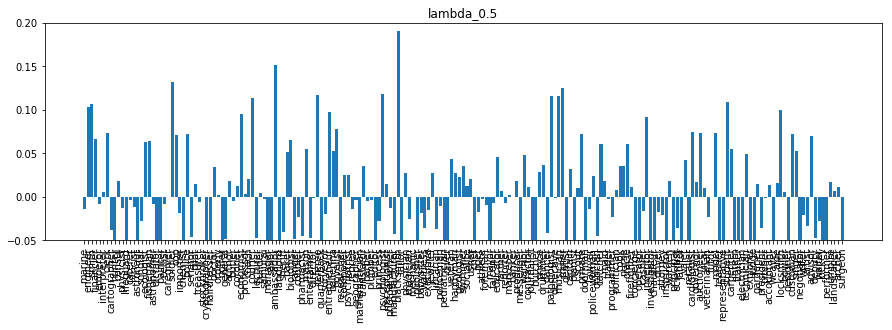

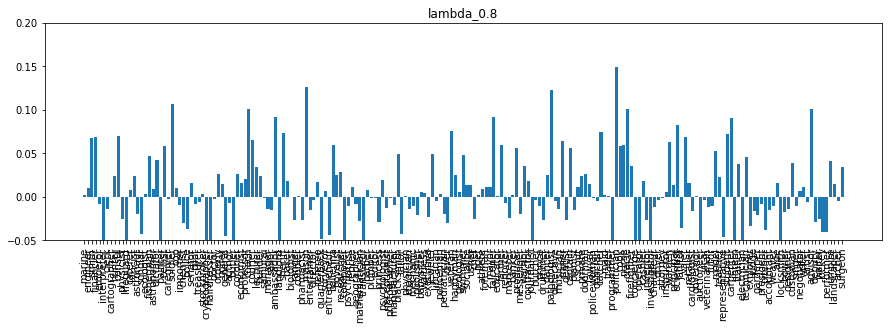

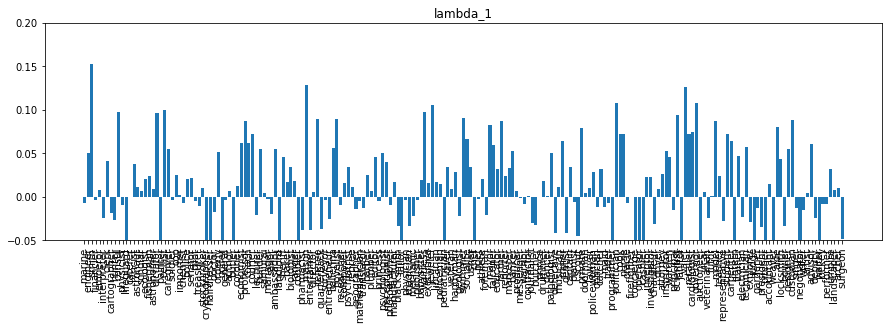

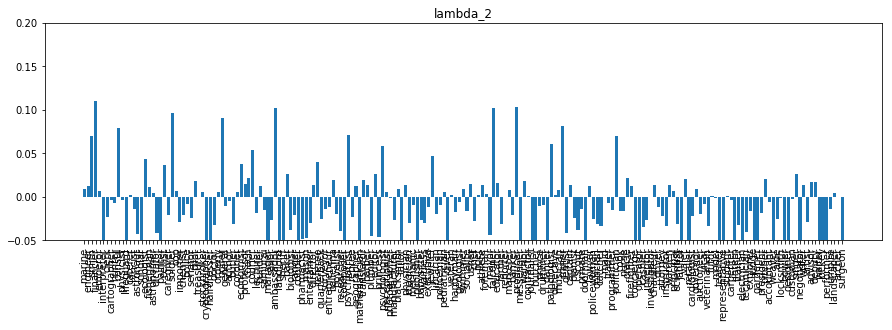

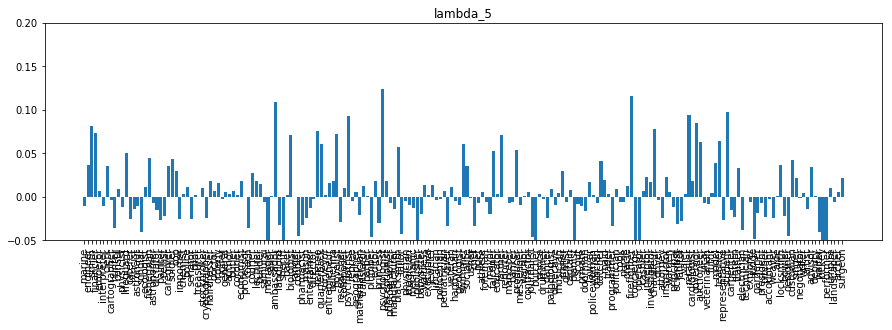

In [23]:
# #biasDist
# for i in range(len(modelsNames)):
#     bdict = biasDict[i]
#     plt.figure(figsize=(15,4))
#     plt.bar(list(bdict.keys()), list(bdict.values()))
#     plt.title(modelsNames[i])
#     plt.ylim((-0.05,0.2))
#     _=plt.xticks(list(bdict.keys()), rotation='vertical')